# BOAR for TAS fitting
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR for fitting transient absorption spectroscopy (TAS) data with rate equations.

Here we use the following rate equations:


$$\frac{dn}{dt} = G - k_{trap} n - k_{direct} n^2$$

where $n$ is the charge carrier density, $G$ is the generation rate in m&#8315;&#179; s&#8315;&#185;, ktrap is the trapping rate in s&#8315;&#185;, and k<sub>direct</sub> is the bimolecular/band-to-bad recombination rate in m&#179; s&#8315;&#185;.

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook

# Import libraries
import sys,os
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar
# import one folder up
sys.path.append('../') # comment out if the Notebook is in the Notebooks folder
from boar import *


In [2]:
# Define the path to the data directory
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '../')) # path to the parent directory
res_dir = os.path.join(parent_dir,'temp') # path to the results directory

### Define the free parameters to be optimized

In [3]:
# define Fitparameters
# create fit parameters for the various processes we have to consider
True_values = {'ktrap': 1e5, 'kdirect': 2e-19, 'QE': 0.9, 'crossec': 2.1e-21}
ktrap = Fitparam(name = 'ktrap', val = True_values['ktrap'] , relRange = 1, range_type = 'log', axis_type='log',
            lim_type = 'relative',optim_type='log', display_name = 'k$_1$', unit = 's$^{-1}$')
kdirect = Fitparam(name = 'kdirect', val =  True_values['kdirect'], relRange = 1, range_type = 'log', axis_type='log',
            lim_type = 'relative',optim_type='log', display_name = 'k$_2$', unit = 'm$^{3}$ s$^{-1}$')
QE = Fitparam(name = 'QE', val =  True_values['QE'], lims = [0.02, 1], relRange = 0, range_type = 'linear', axis_type='linear',
            lim_type = 'absolute',optim_type = 'linear', display_name = 'QE', unit = '%')
crossec = Fitparam(name = 'crossec', val =  True_values['crossec'], lims = [1e-21, 5e-21], relRange = 1, range_type = 'linear',
            lim_type = 'absolute',optim_type = 'linear', axis_type='log',display_name= '$\sigma$', unit = 'm$^2$')

params = [ktrap,kdirect,QE,crossec] # pass all these fit parameters to the system.

### Prepare fake data for fitting
In the next block we create some fake data with some random noise and plot it.

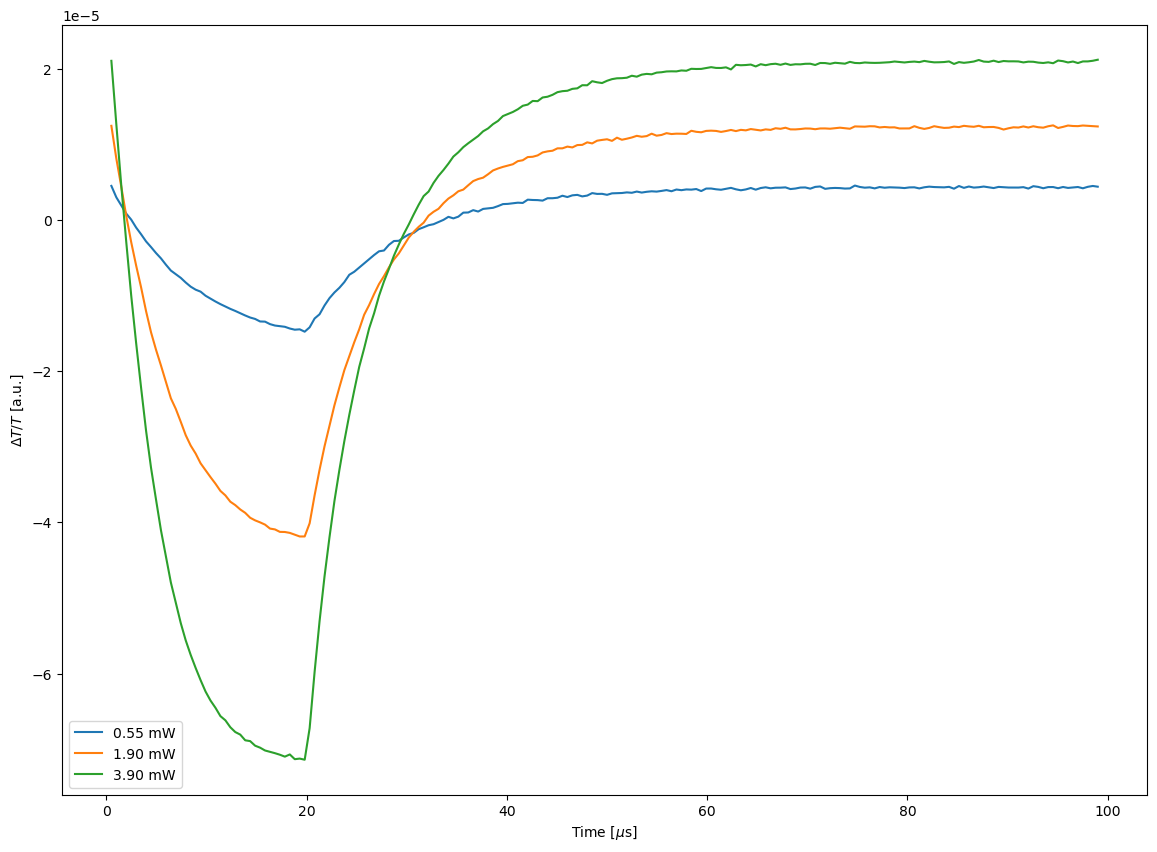

In [4]:
# Make fake data
rng = default_rng()
noise = 1e-7
preals = [0.00055, 0.0019, 0.0039] # real Power in W
fpu = 10000 # pump frequency in Hz
wvl = 850 # excitation wavelength in nm
A = 0.3*0.3*1e-4 # effective pump area in m^-2
alpha = 1e-5*1e-2 # penetration depth in m
pulse_width = 0.2*(1/fpu) # width of the pump pulse in seconds
t0 = 0 # time offset of the pump pulse in seconds
background = 0 # background pump density in m^-3
thickness = 100e-9
# create a pump pulse
x1 = np.linspace(1/fpu/200,0.99*1/fpu,200)
X_dimensions = ['t','P']

X,y,weight = [],[],[]
tas = TAS_agent()
tas.pump_params['fpu'] = fpu
tas.pump_params['wvl'] = wvl
tas.pump_params['A'] = A
tas.pump_params['alpha'] = alpha
tas.pump_params['pulse_width'] = pulse_width
tas.pump_params['t0'] = t0
tas.pump_params['background'] = background
tas.pump_params['thickness'] = thickness

plt.figure(figsize=(14,10))
for prealx in preals:
    # get absorbed density ( in cm-3) of pump photons
    X1 =  [[xx, prealx] for xx in x1]
    X = X +  X1
    y1 = tas.TAS(np.asarray(X1), params, X_dimensions=X_dimensions) + rng.standard_normal(len(X1))*noise
    y = y + list(y1)
    #weight = weight + list(1/np.abs(y1)) # careful! Can become zero! 
    weight = weight + list(1/(np.abs(y1)**0.0)) # 
    plt.plot(x1*1e6,y1,label=f'{prealx*1000:.2f} mW') 


plt.ylabel(r'$\Delta T/T$ [a.u.]')
plt.xlabel('Time [$\mu$s]')
plt.legend()

X = np.array(X)
y = np.array(y)
weight = np.array(weight)
weight/=np.mean(weight)
weight[weight>10]=10    


### Start the optimization

Scaling runs for target 0:   0%|          | 0/1 [00:00<?, ?it/s]

Starting with initial points


Initial points:   0%|          | 0/3 [00:00<?, ?it/s]

Initial points done in 4.52 s
Starting with BO


BO runs:   0%|          | 0/15 [00:00<?, ?it/s]

BO done in 84.28 s
Ground truth minimum at: [4.994019055672747, -18.698352204002852, 2.0983188347936905] with function value: 0.0014448162013030548
Minimum of surrogate function: [4.994243599925428, -18.698055697229833, 2.0986959629449156] with function value 0.0014854977793419266
Sampling for posterior distribution done in  0.08959674835205078 s


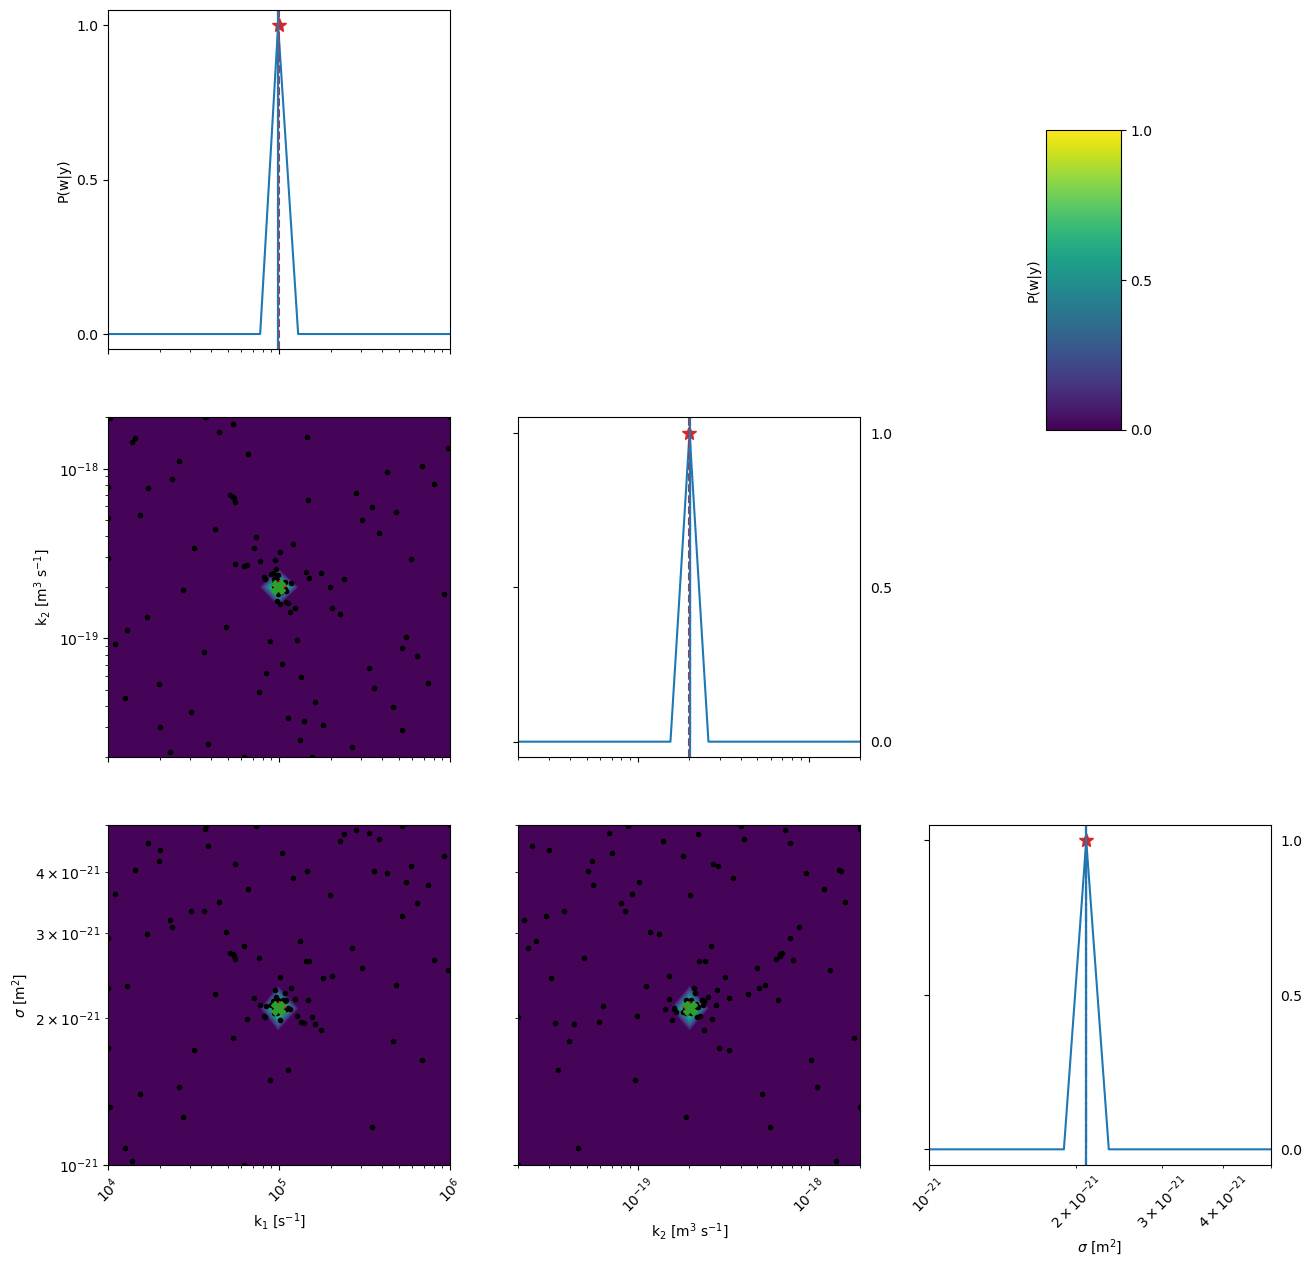

In [5]:
# start multiobjective optimization
X_dimensions = ['t','P']
y_dimension = r'$\Delta T/T$'
target = {'model':partial(tas.TAS,X_dimensions=X_dimensions),'target_name':'TAS',
          'data':{'X':X,'y':y,'X_dimensions':X_dimensions,'X_units':['s','W'],'y_dimension':y_dimension,'y_unit':''}
            , 'weight':1,'target_weight':1}

targets = [target]
mo = MultiObjectiveOptimizer(targets = targets,params=params)

n_jobs = 4 # was 4
n_jobs_init = 20 # was 4
n_yscale=20 # was 20
n_BO = 20 # was 60
n_initial_points = 60 # was 200
n_BO_warmstart = 20 # was 5

targets = [target]
mo = MultiObjectiveOptimizer(targets = targets, params=params, res_dir=res_dir)

# define the optimization parameters
n_jobs = 4 
n_jobs_init = 20 
n_yscale=20 
n_initial_points = 60 
n_BO = 60
n_BO_warmstart = 20 

mo.warmstart = 'None' # whether to use warmstart to recall or collect points or not
mo.SaveOldXY2file = os.path.join(res_dir,'old_XY.json') # path to the file where old points are saved
mo.Path2OldXY = os.path.join(res_dir,'old_XY.json') # path to the file where old points are saved
kwargs = {'check_improvement':'relax','max_loop_no_improvement':10,'xtol':1e-3,'ftol':1e-3}
kwargs_posterior = {'Nres':10,'Ninteg':1e5,'logscale':False,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'show_points':True,'savefig':False,'figname':'param_posterior','True_values':True_values,'full_grid':True}
kwargs_plot_obj = {'zscale':'linear'}

r = mo.optimize_sko_parallel(n_jobs=n_jobs,n_yscale=n_yscale, n_BO=n_BO, n_initial_points = n_initial_points,n_BO_warmstart=n_BO_warmstart,n_jobs_init=n_jobs_init,kwargs=kwargs,verbose=False,loss='linear',threshold=100,base_estimator = 'GP',show_objective_func=False,show_posterior=True,kwargs_posterior = kwargs_posterior,kwargs_plot_obj=kwargs_plot_obj)
    

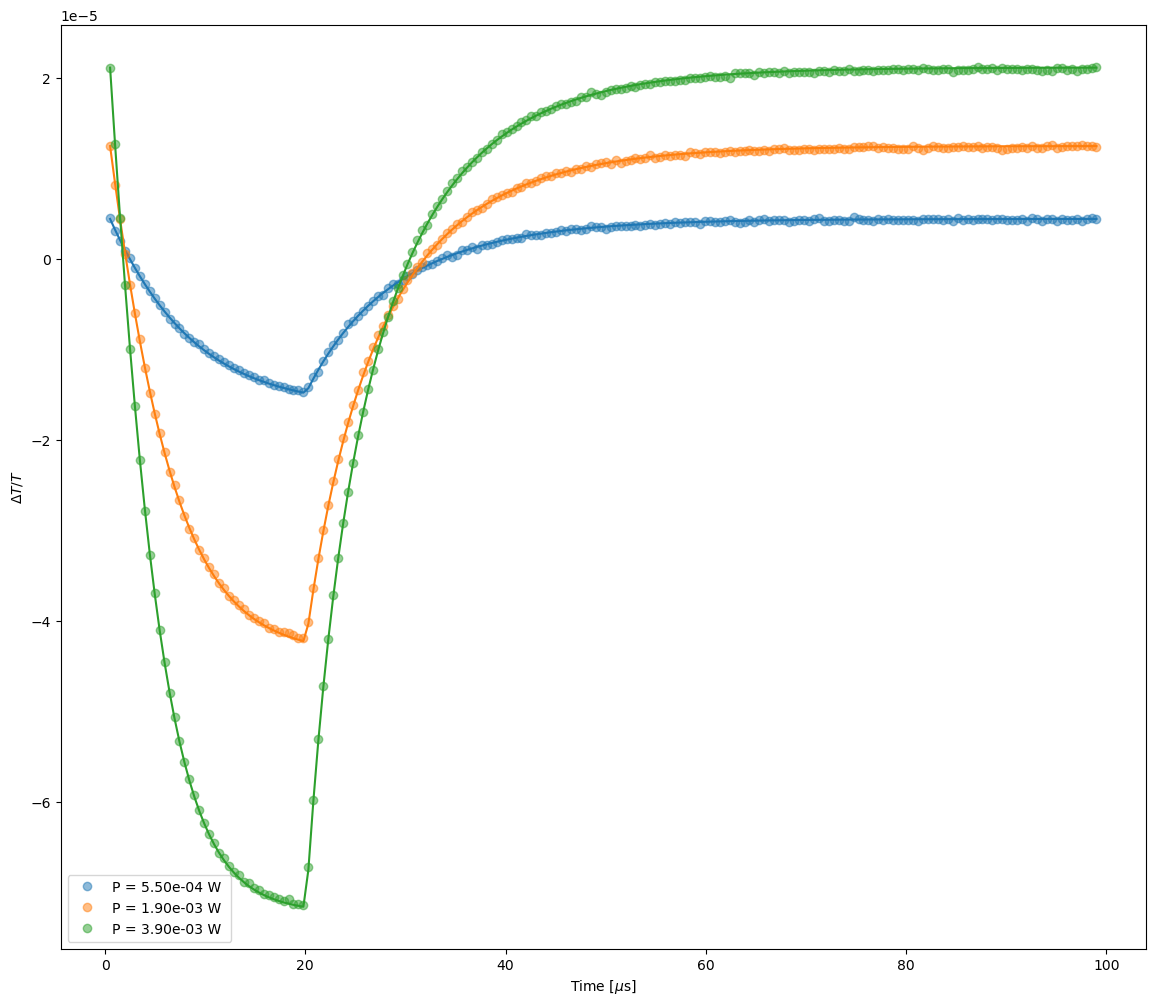

In [6]:
# Plot and save the results
fit_results = []
kwargs_plot_res = {'x_scaling':1e6,'xaxis_label':'Time [$\mu$s]','xscale_type':'linear','yscale_type':'linear','norm_data':False,'delog':False,'figsize':(14,12)}

for num,t in enumerate(targets):
    kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
    tas.plot_fit_res(t,mo.params,'t',xlim=[],ylim=[],kwargs=kwargs_plot_res)

    X = t['data']['X']
    y = t['data']['y']
    X_dimensions = t['data']['X_dimensions']
    yfit = t['model'](X,mo.params,X_dimensions=X_dimensions) # get the best fits

    data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
    fit_results.append(data)

# prepare the data for saving
param_dict = tas.get_param_dict(mo.params) # get fitparameters (and fixed ones)

pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict]

save_output = False
if save_output:
    # produce output excel file with data, fitparameters and FOMs
    fn_xlsx = 'fits_results.xlsx'
    namecols = X_dimensions + ['TASexp','TASfit']
    # delete old file if it exists
    if os.path.exists(os.path.join(res_dir,fn_xlsx)):
        os.remove(os.path.join(res_dir,fn_xlsx))

    with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
        for i,t in enumerate(targets):
            if 'target_name' in t.keys():
                tname = t['target_name']
            else: 
                tname = 'data'
            namecols = X_dimensions + [tname+'_exp',tname+'_fit']
            df = pd.DataFrame(fit_results[i],columns=namecols)
            df.to_excel(writer, sheet_name = tname+f'_{i}')
        
        df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
        df.to_excel(writer, sheet_name = f'params')


P1sun = 1000 W/m^2, Pw = 9.00e-03 W


(-210.0, 20.0)

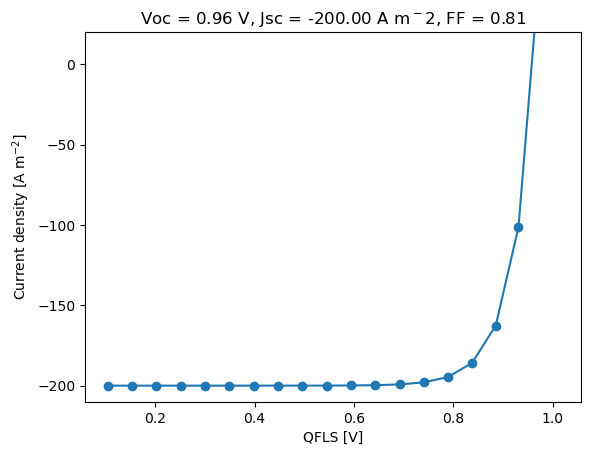

In [7]:
# Calculate the pseudo-JV curve 
Ps = np.logspace(-10,-2,20) # make a power sweep
Eg = 1.39 # eV
Nc = 5e26 # m^-3
currents,QFLS= tas.get_pseudo_JV(mo.params, Ps, Eg, Nc, T = 293)
P1sun = 1000 # W/m^2
Pw = 1000*A # W  convert to W
print(f'P1sun = {P1sun} W/m^2, Pw = {Pw:.2e} W')
plt.figure()
J1sun = np.interp(Pw,Ps,currents)
J1sun = 200
plt.plot(QFLS,currents-J1sun,'o-')
from boar.SIMsalabim_utils.aux_func import get_Voc,get_FF,get_Jsc
Voc = get_Voc(QFLS,currents-J1sun)
FF = get_FF(QFLS,currents-J1sun)
Jsc = get_Jsc(QFLS,currents-J1sun)
plt.title(f'Voc = {Voc:.2f} V, Jsc = {Jsc:.2f} A m$^{-2}$, FF = {FF:.2f}')
plt.xlabel('QFLS [V]')
plt.ylabel('Current density [A m$^{-2}$]')
plt.ylim([-210,20])

In [8]:
# Clean output files from simulation folders
from boar.SIMsalabim_utils.CleanFolder import *
Do_Cleaning = False # Careful, this will delete all files in the folder
if Do_Cleaning:
    # delete old_xy.json file if it exists
    # os.remove(mo.path2oldxy) # remove the old_xy.json file if it exists
    # delete warmstart folder if it exists
    if os.path.exists(os.path.join(parent_dir,'warmstart/')):
        shutil.rmtree(os.path.join(os.getcwd(),'warmstart/'))
    # delete temp folder if it exists
    if os.path.exists(res_dir):
        shutil.rmtree(res_dir)
